In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial, cache
from copy import deepcopy
from pathlib import Path

from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np

import scipy
import scipy.stats
import scipy.integrate

import torch
import torch.distributions

import sbi
import sbi.analysis as analysis
from sbi.inference import SNRE_A, SNRE_B, prepare_for_sbi
from sbi.utils.get_nn_models import classifier_nn

import sbibm

import cnre

## setup problem

In [3]:
num_training_samples = 10_000
num_validation_samples = 10_000
num_total_samples = num_training_samples + num_validation_samples
num_posterior_samples = 2_000

training_batch_size=256
learning_rate=5e-4
validation_fraction=0.5
stop_after_epochs=2 ** 31 - 1
# max_num_epochs=1_000  # We want the network to see the same number of batches no matter how much data we provide
num_batches_to_see = 8_000
clip_max_norm=None

classifier_kwargs = dict(
    model='resnet', 
    hidden_features=50, 
    num_blocks=2,
    dropout_probability=0.0,
    use_batch_norm=True
)
sample_with = "rejection"

device = "cpu"
root = Path("figures")

In [4]:
kind = "slcp"
if kind == "parabola":
    dimension = 3
    low = -torch.ones(dimension).mul(3.).sqrt().to(device)
    high = torch.ones(dimension).mul(3.).sqrt().to(device)
    limits = torch.stack([low.cpu(), high.cpu()], dim=-1).numpy()
    prior = sbi.utils.BoxUniform(low=low, high=high, device=device)
    task = cnre.Parabola(scale=0.1)
    simulate = task.simulate
    simulator, prior = prepare_for_sbi(simulate, prior)
    true_theta = torch.ones(dimension).to(device).unsqueeze(0)
    observation = simulator(true_theta)
elif kind == "gaussian":
    dimension = 3
    low = -torch.ones(dimension).mul(3.).sqrt().to(device)
    high = torch.ones(dimension).mul(3.).sqrt().to(device)
    limits = torch.stack([low.cpu(), high.cpu()], dim=-1).numpy()
    prior = sbi.utils.BoxUniform(low=low, high=high, device=device)
    task = cnre.Gaussian(scale=0.1)
    simulate = task.simulate
    simulator, prior = prepare_for_sbi(simulate, prior)
    true_theta = torch.ones(dimension).to(device).unsqueeze(0)
    observation = simulator(true_theta)
elif kind == "slcp":
    tt = sbibm.get_task("slcp")
    num_observation = 1
    simulator = tt.get_simulator()
    prior = tt.get_prior_dist()
    dimension = tt.dim_data
    observation = tt.get_observation(num_observation)
    true_theta = tt.get_true_parameters(num_observation)
else:
    raise NotImplementedError


theta = prior.sample((num_total_samples,)).to(device)
x = simulator(theta).to(device)

In [5]:
get_classifier = classifier_nn(**classifier_kwargs)
classifier = get_classifier(theta[:512, ...], x[:512, ...])
classifier.to(device)

# optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum)
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

## experiment

In [6]:
dataset = torch.utils.data.TensorDataset(theta, x)
train_set, valid_set = torch.utils.data.random_split(dataset, [num_training_samples, num_validation_samples])
train_loader = torch.utils.data.DataLoader(train_set, training_batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, training_batch_size, drop_last=True)

In [7]:
max_num_epochs = round(num_batches_to_see / len(train_loader))
max_num_epochs

205

In [8]:
torch.manual_seed(0)
l1 = cnre.loss_bce(classifier, theta[:256], x[:256])
torch.manual_seed(0)
l2 = cnre.loss(classifier, theta[:256], x[:256], 2, gamma=1.0, reuse=True)

# The issue here is that the BCE takes the mean of more terms, my version doesn't do that.
# l2 - l1.reshape(-1, 2).sum(dim=-1) * 0.5
# l2.mean() - l1.mean()
l2 - l1

tensor(5.9605e-08, grad_fn=<SubBackward0>)

In [9]:
def doit(num_atoms: int):
    gamma = 1.0
    results = cnre.algorithms.cnre.train(
        classifier, 
        optimizer, 
        max_num_epochs, 
        train_loader, 
        valid_loader, 
        num_atoms,
        gamma=gamma,
    )
    name = f"num atoms {num_atoms}"
    plt.plot(results['valid_losses'])
    plt.title(name)
    classifier.load_state_dict(results["best_network_state_dict"])
    posterior = cnre.get_sbi_posterior(
        ratio_estimator=classifier,
        prior=prior,
        sample_with="rejection", 
        mcmc_method="slice_np",
        mcmc_parameters={},
        rejection_sampling_parameters={},
    )
    samples = posterior.sample((num_posterior_samples,), x=observation.cpu())
    fig, _ = analysis.pairplot(
        samples.cpu().numpy(), 
        figsize=(6,6), 
        points=true_theta.cpu().numpy(),
        title=name,
        # limits=limits,
    )

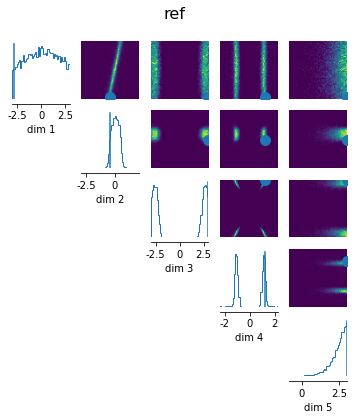

In [10]:
name = f"ref"
fig, _ = analysis.pairplot(
    tt.get_reference_posterior_samples(num_observation), 
    figsize=(6,6), 
    points=true_theta.cpu().numpy(),
    title=name,
    # limits=limits,
)

### gilles

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 1993
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


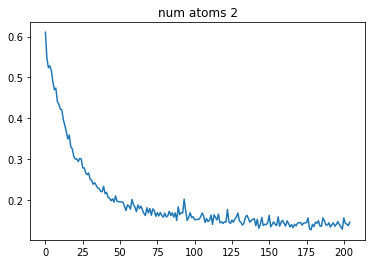

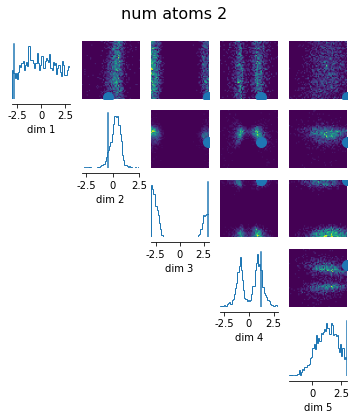

In [11]:
doit(num_atoms=2)

### ours

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 1999
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


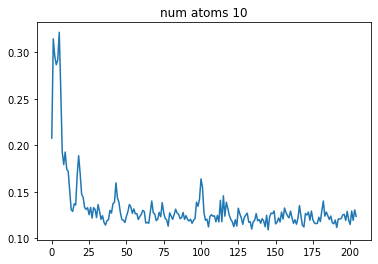

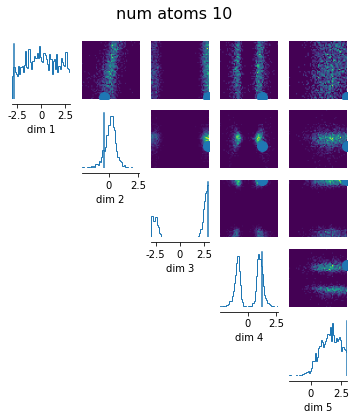

In [12]:
doit(num_atoms=10)